In [1]:
from model import Model
from texts import prepare_pile, prepare_code
import torch

In [2]:
def prepare( dataset_name ):
    if dataset_name == 'pile':
        return prepare_pile()
    if dataset_name == 'code':
        return prepare_code()

opt = Model()

 - Registered 12 OPT Attention Layers


In [3]:
from random import sample
from tqdm import tqdm

def setup_counter(ff_keys):
    shape = ff_keys.size()
    counter = []
    for i in range(shape[0]):
        counter.append( torch.zeros( shape[-1]))
    return torch.stack(counter)

def count_keys( dataset_name, limit=1000, sample_size=10000, num_samples=2 ):
    dataset, label, skip_eval = prepare( dataset_name )
    counters = []
    counter = None
    curr_count = 0
    with tqdm(total=sample_size*num_samples) as pbar:
        for data in dataset:
            text = data[label]
            input_ids = opt.get_ids( text, limit=limit )
            curr_count += len(input_ids[0])

            ff_keys = opt.get_ff_key_activations(input_ids=input_ids)
            if counter is None:
                counter = setup_counter(ff_keys)
            for index, layer in enumerate(ff_keys):
                for token in layer:
                    counter[index] += ( token != 0 )

            pbar.update( len(input_ids[0]) ) 
            if curr_count > sample_size:
                counter = counter / curr_count
                counters.append( counter )
                print( f'sample {len(counters)}: {curr_count}' )
                
                counter = setup_counter(ff_keys)
                curr_count = 0
            
            if len( counters ) >= num_samples:
                break
    
    return torch.stack( counters )

def acc_str( acc, pred ):
    return f"{100*round(acc/pred, 2)}% - ( {acc}/{pred} )"

def evaluate( dataset_name, limit : int = 1e6 ):
    dataset, label, skip_eval = prepare( dataset_name )
    out = opt.evaluate_dataset( dataset, token_limit=1000, k=1,
        start_index=1, stopping_index=limit, skip_eval=skip_eval,
        dataset_text_label=label, count_tokens=False, verbose=True )
    print( f'{dataset_name} w/ skip:', 
        acc_str(out['num_skip_accurate'], out['num_skip_predictions']) )
    print( f'{dataset_name} no skip:',
        acc_str( out['num_accurate'], out['num_predictions']) )
    return out

def evaluate_all( limit: int = 1e5 ):
    pile_out = evaluate( 'pile', limit )

    code_out = evaluate( 'code', limit )

In [4]:
evaluate_all( 10000 )

No config specified, defaulting to: the_pile/all
accuracy 38.7% (curr 66.9%): : 10381it [01:38, 104.88it/s]                        


pile w/ skip: 39.0% - ( 4022/10381 )
pile no skip: 49.0% - ( 8109/16445 )


Using custom data configuration codeparrot--codeparrot-clean-valid-826c6fd8b27e5523
Found cached dataset json (/config/.cache/huggingface/datasets/codeparrot___json/codeparrot--codeparrot-clean-valid-826c6fd8b27e5523/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

accuracy 42.9% (curr 31.7%): : 10209it [01:55, 88.42it/s]                         

code w/ skip: 43.0% - ( 4381/10209 )
code no skip: 60.0% - ( 12974/21528 )


In [5]:
pile_counters = count_keys( 'pile', sample_size=5e4 )
print( pile_counters.size() )

code_counters = count_keys( 'code', sample_size=5e4 )
print( code_counters.size() )

No config specified, defaulting to: the_pile/all
 27%|██▋       | 26734/100000.0 [02:19<06:18, 193.57it/s]

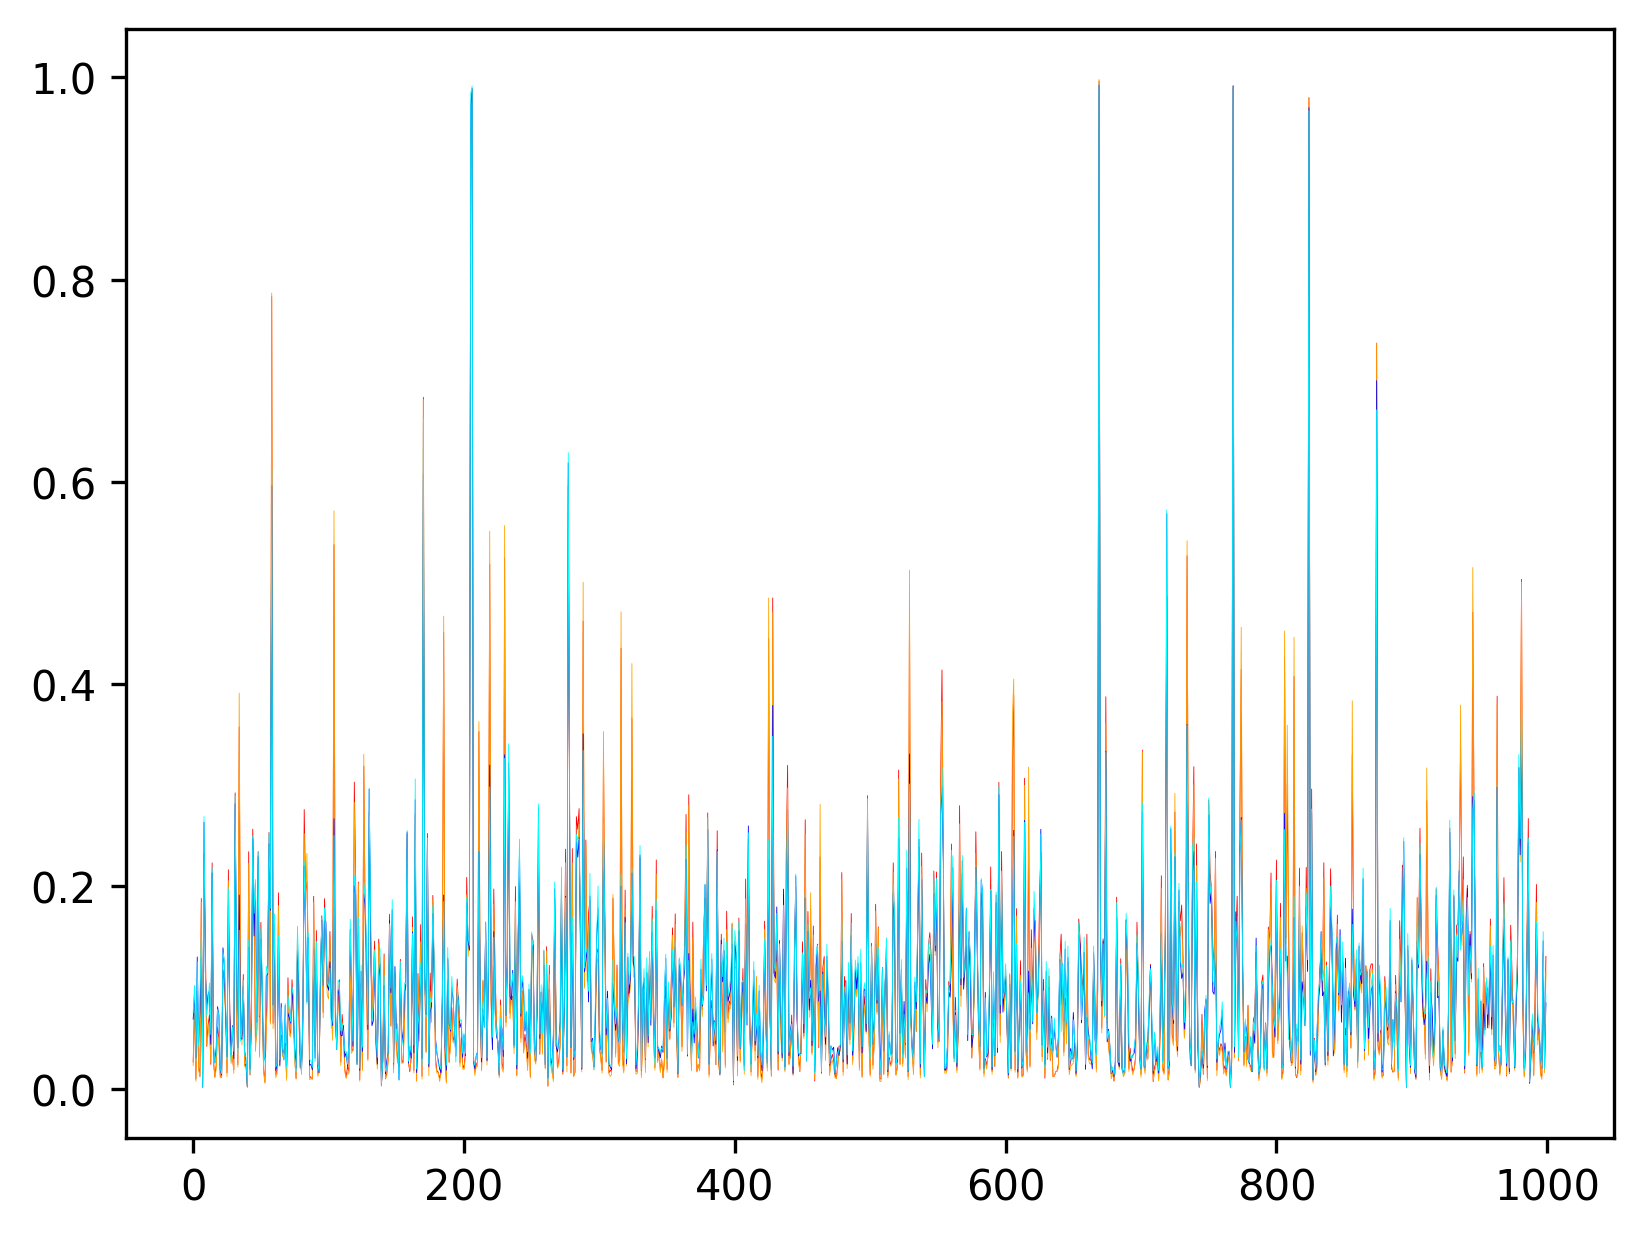

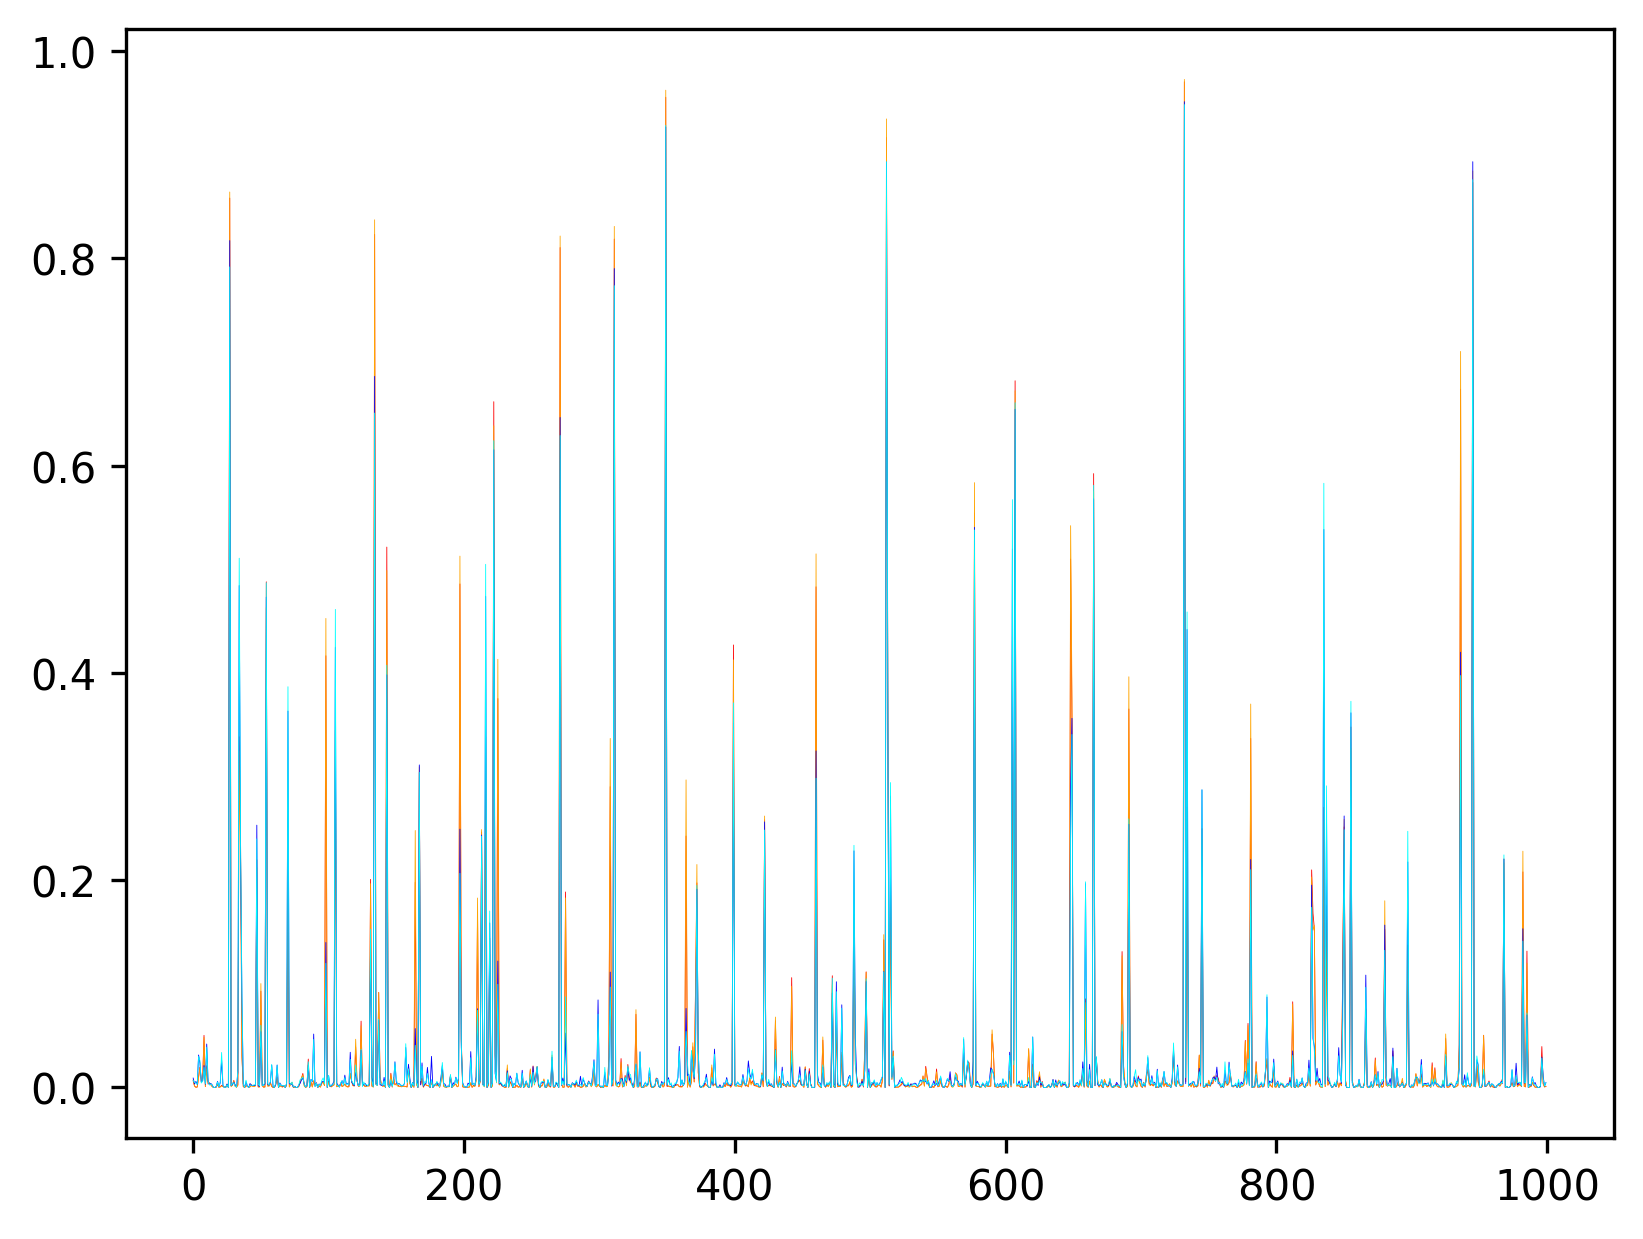

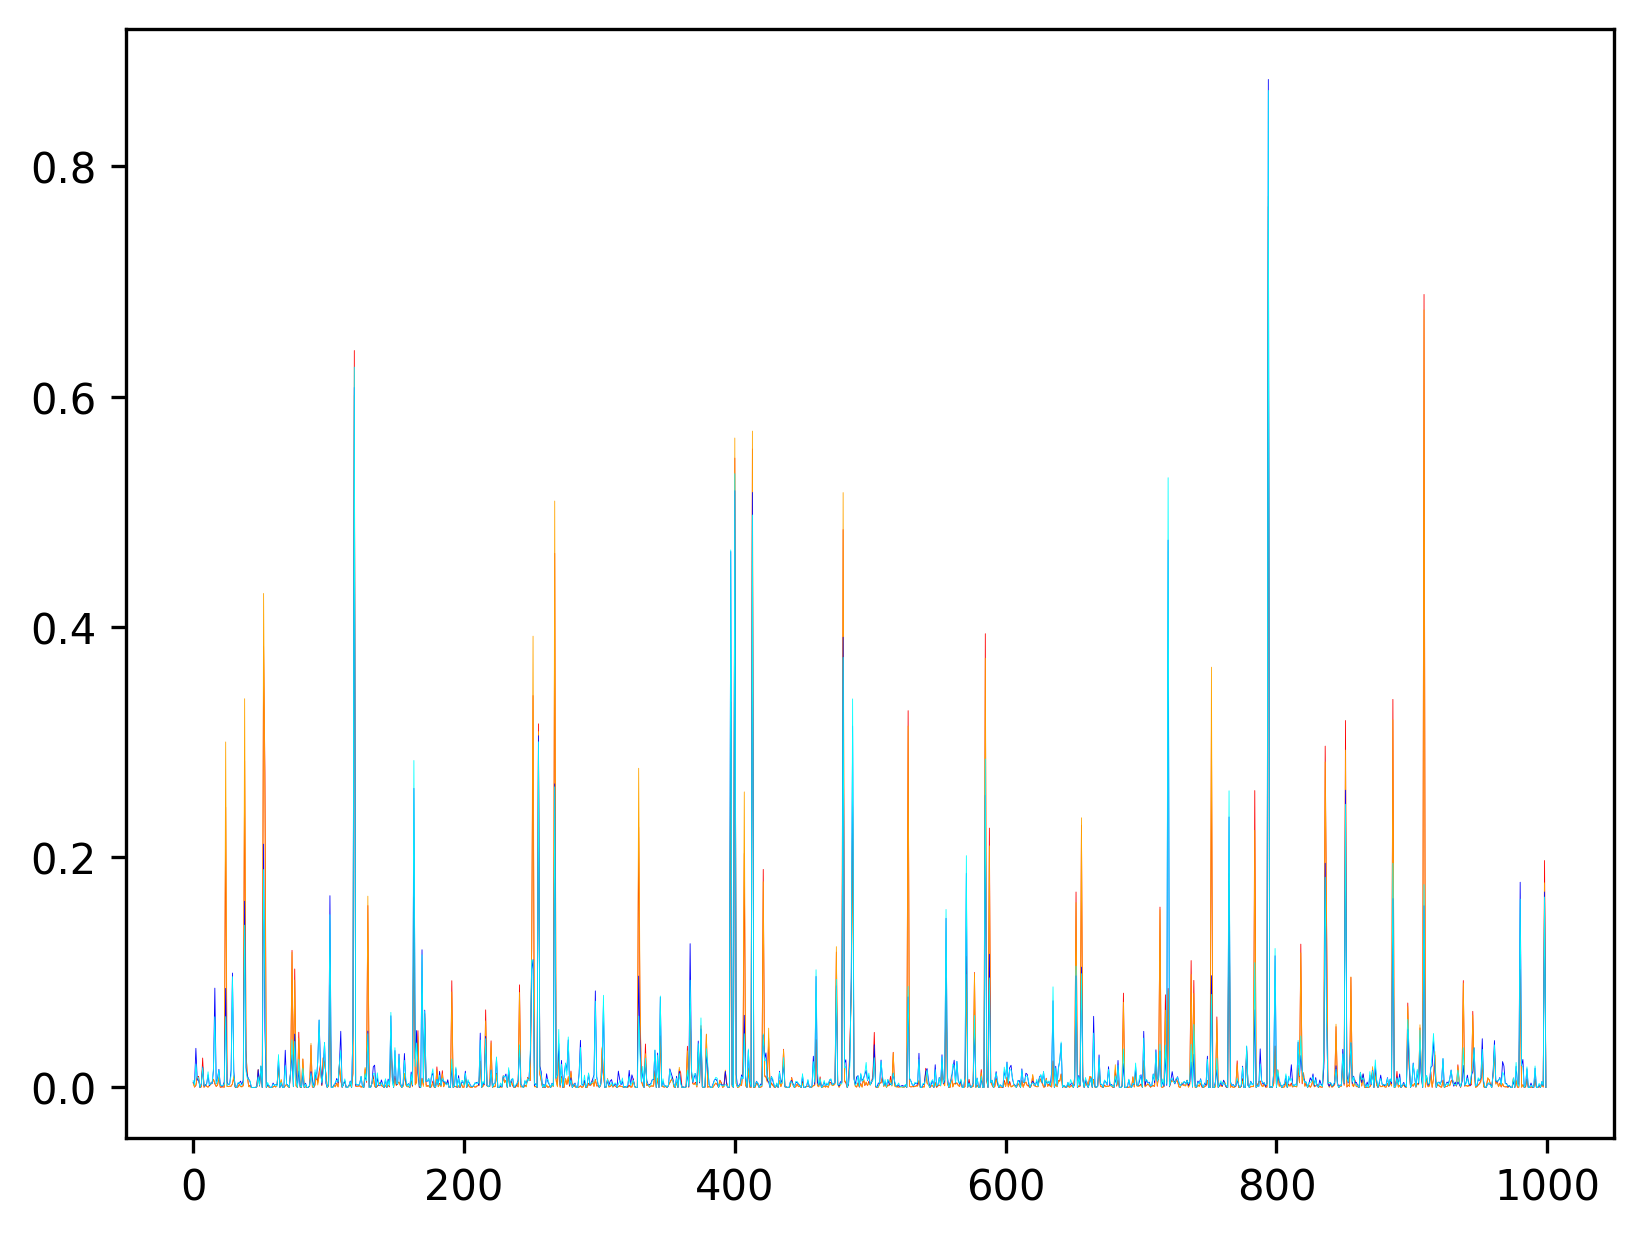

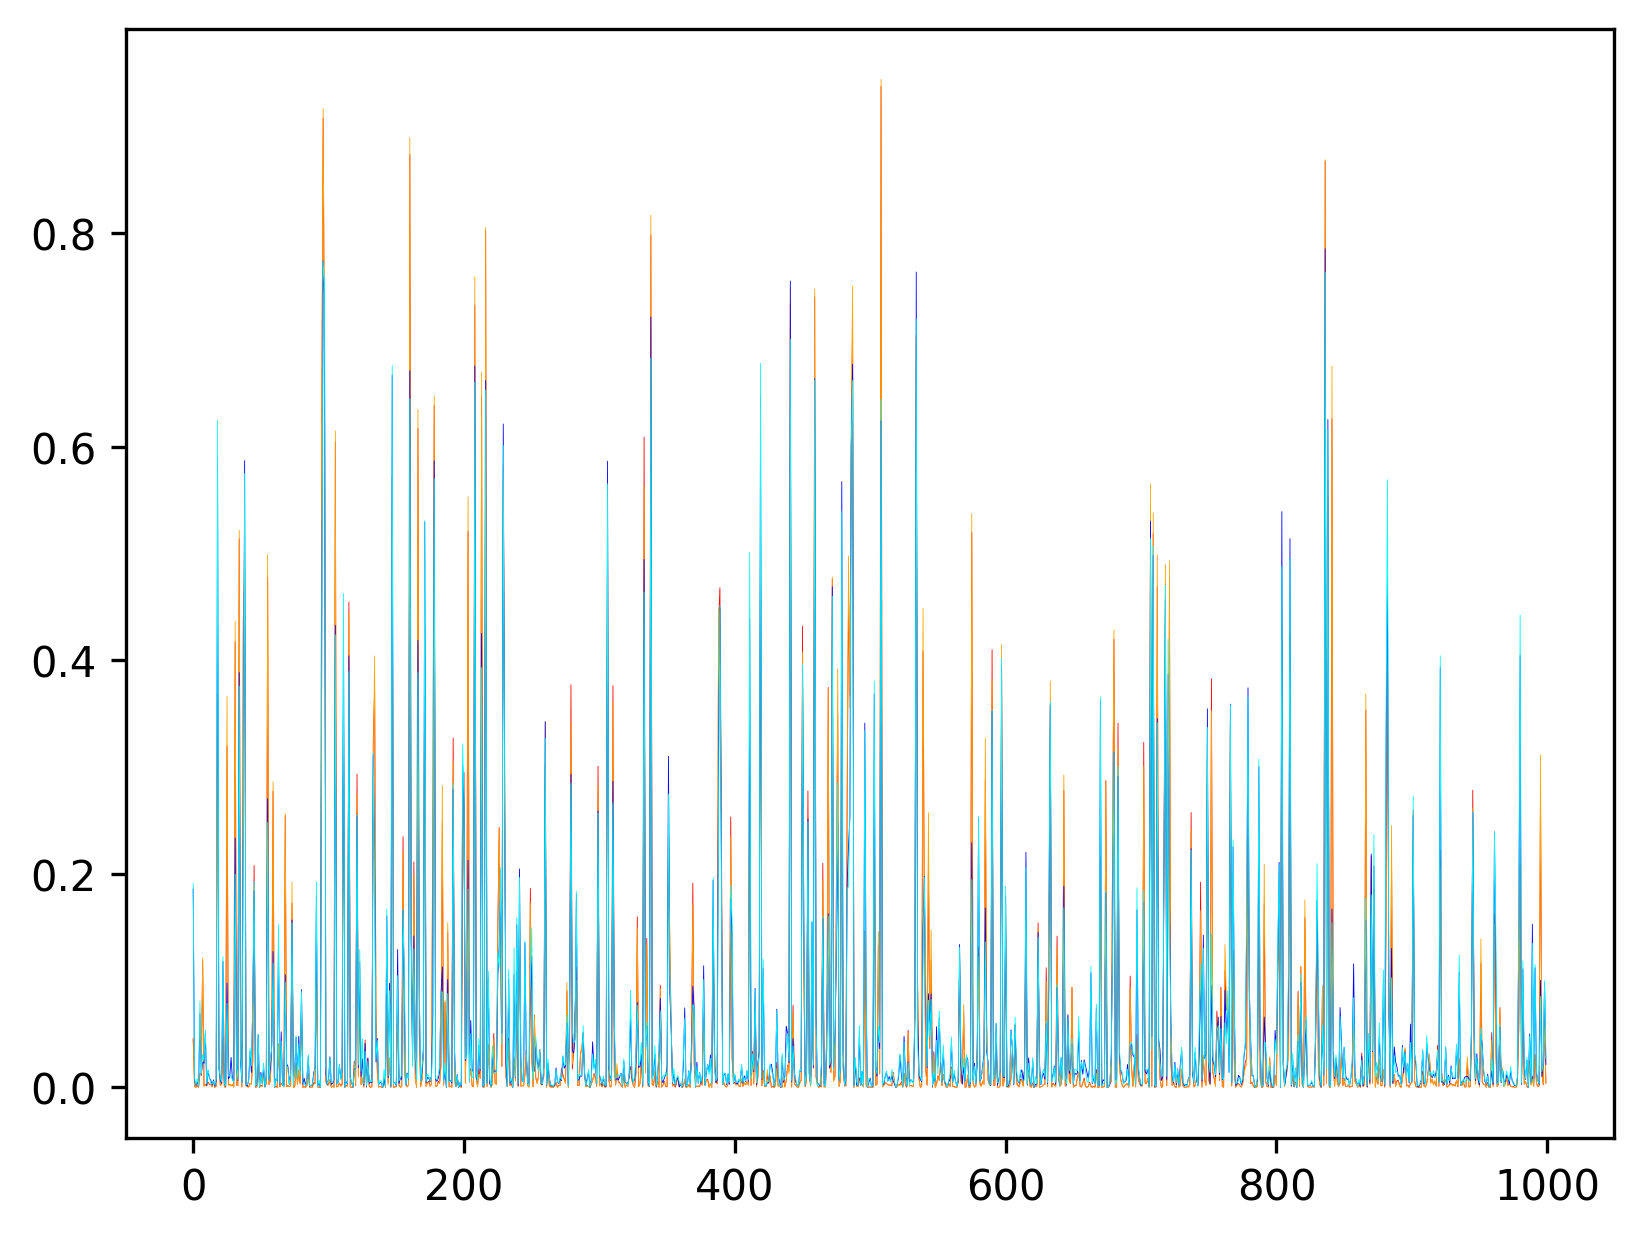

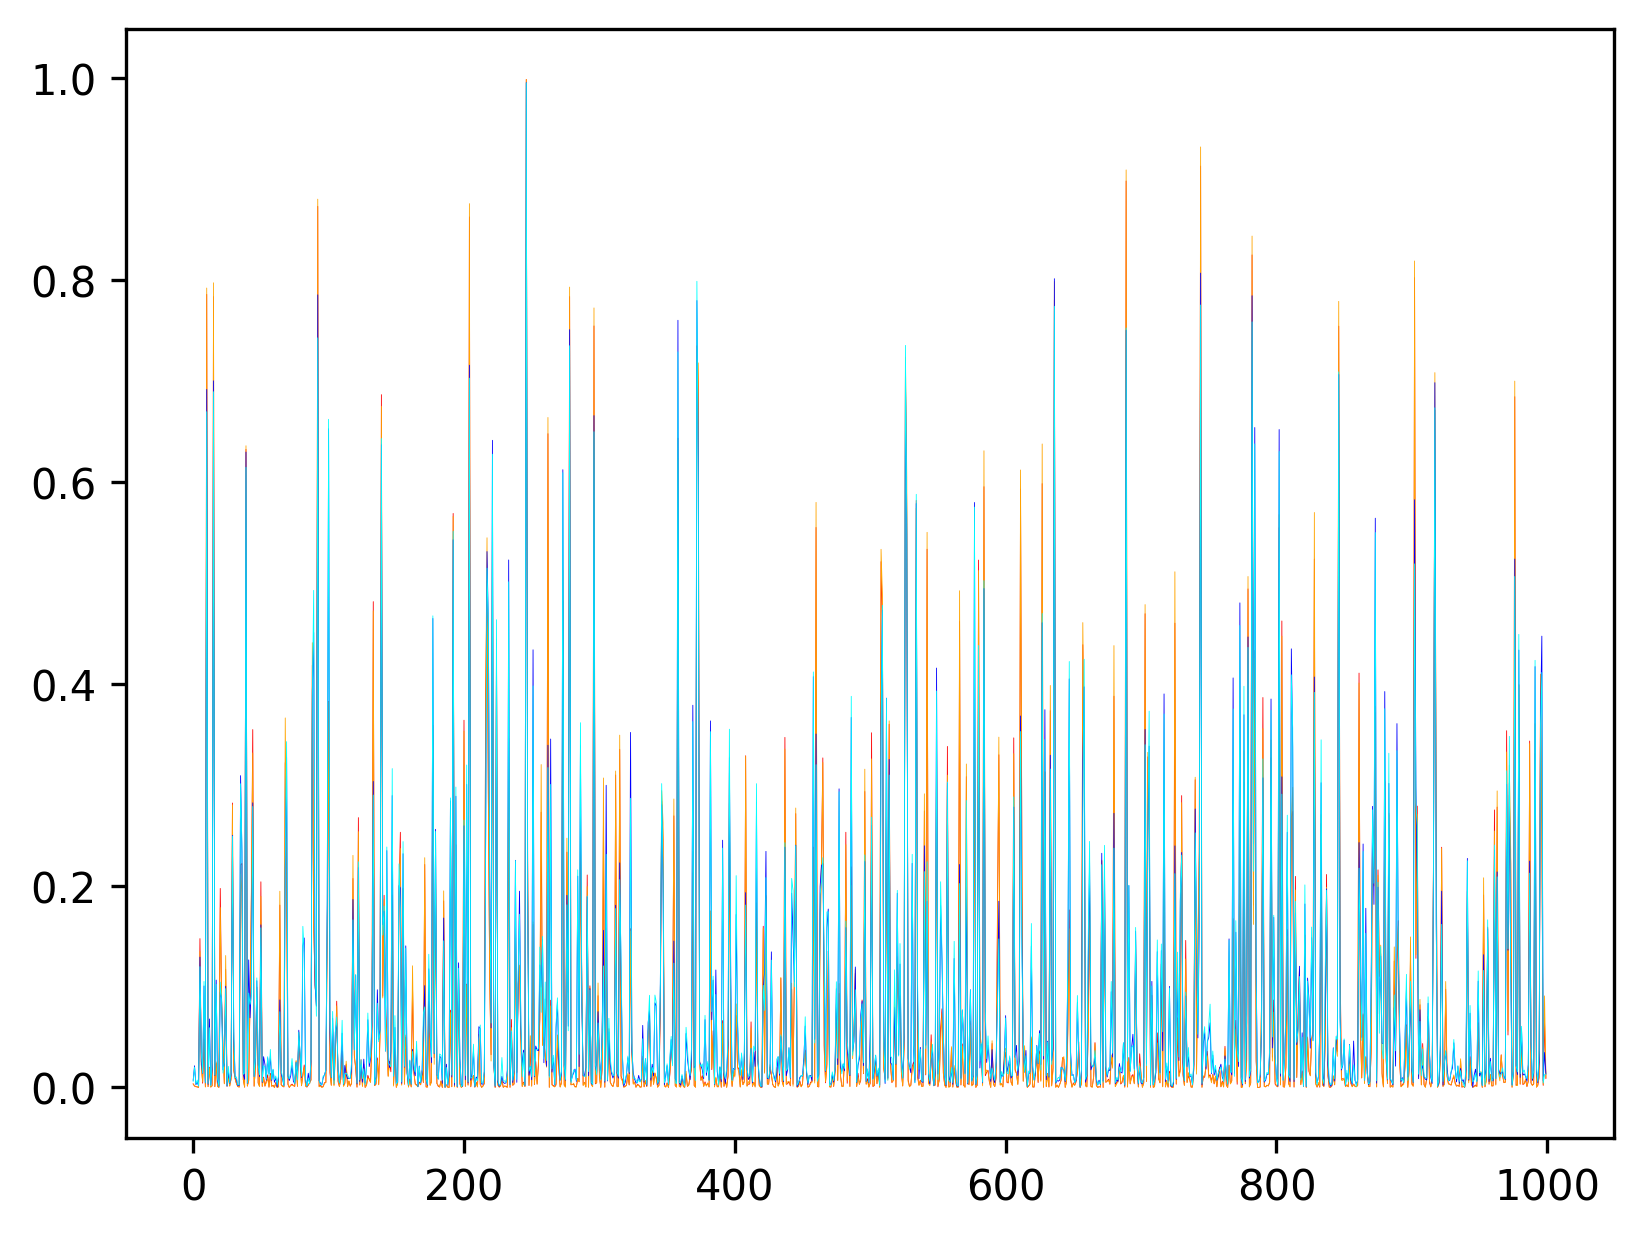

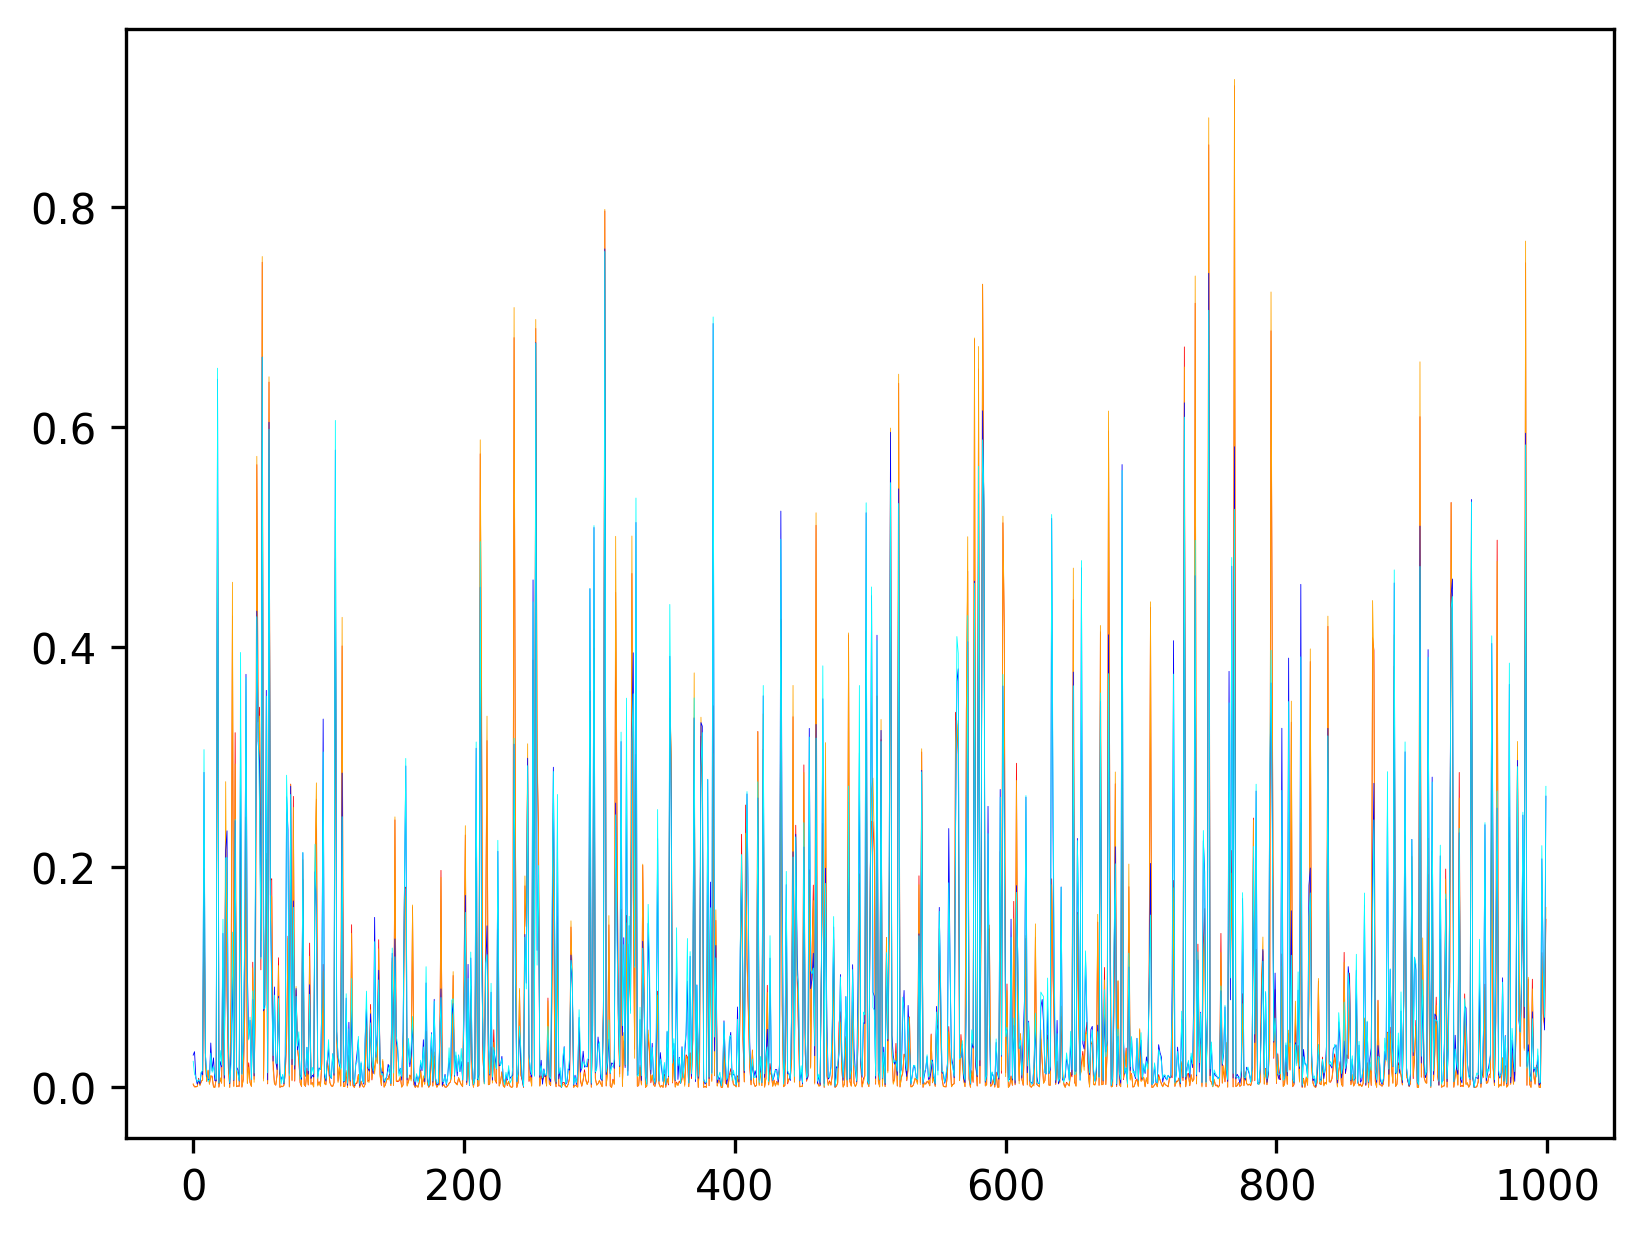

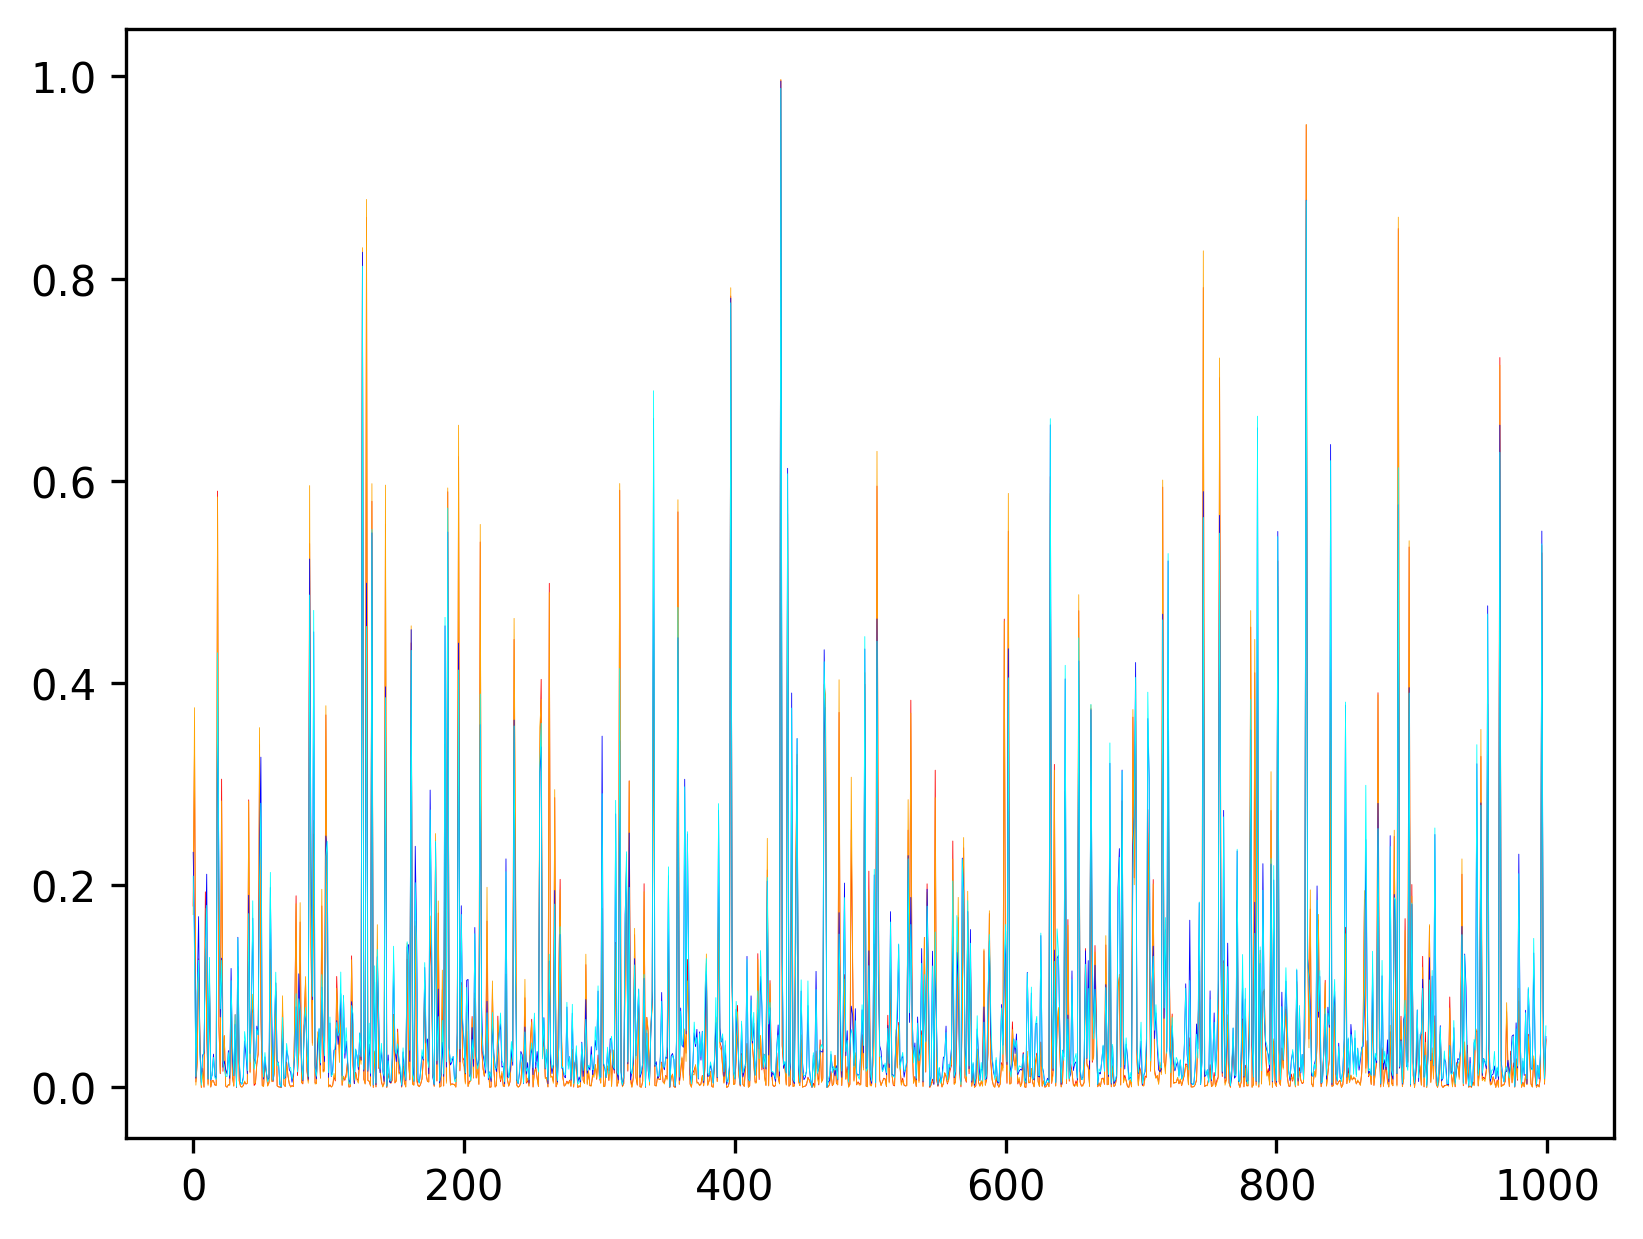

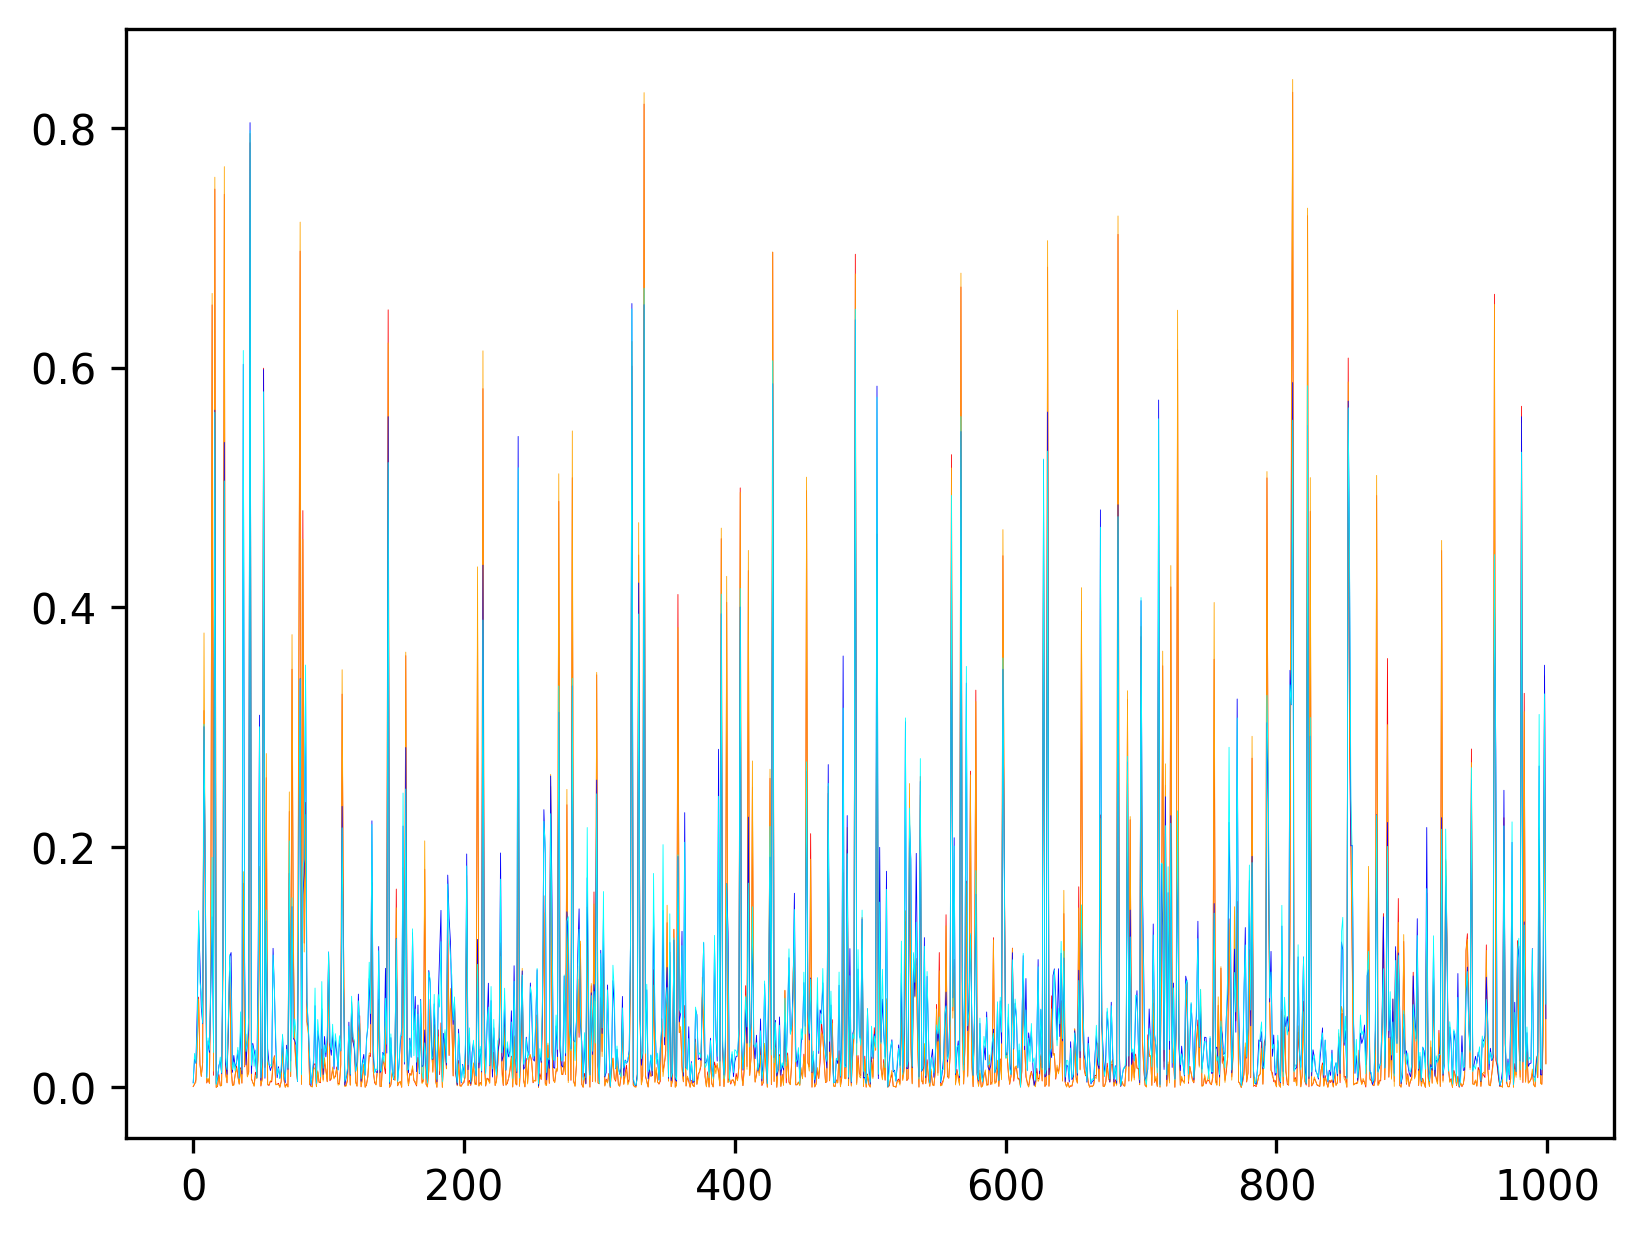

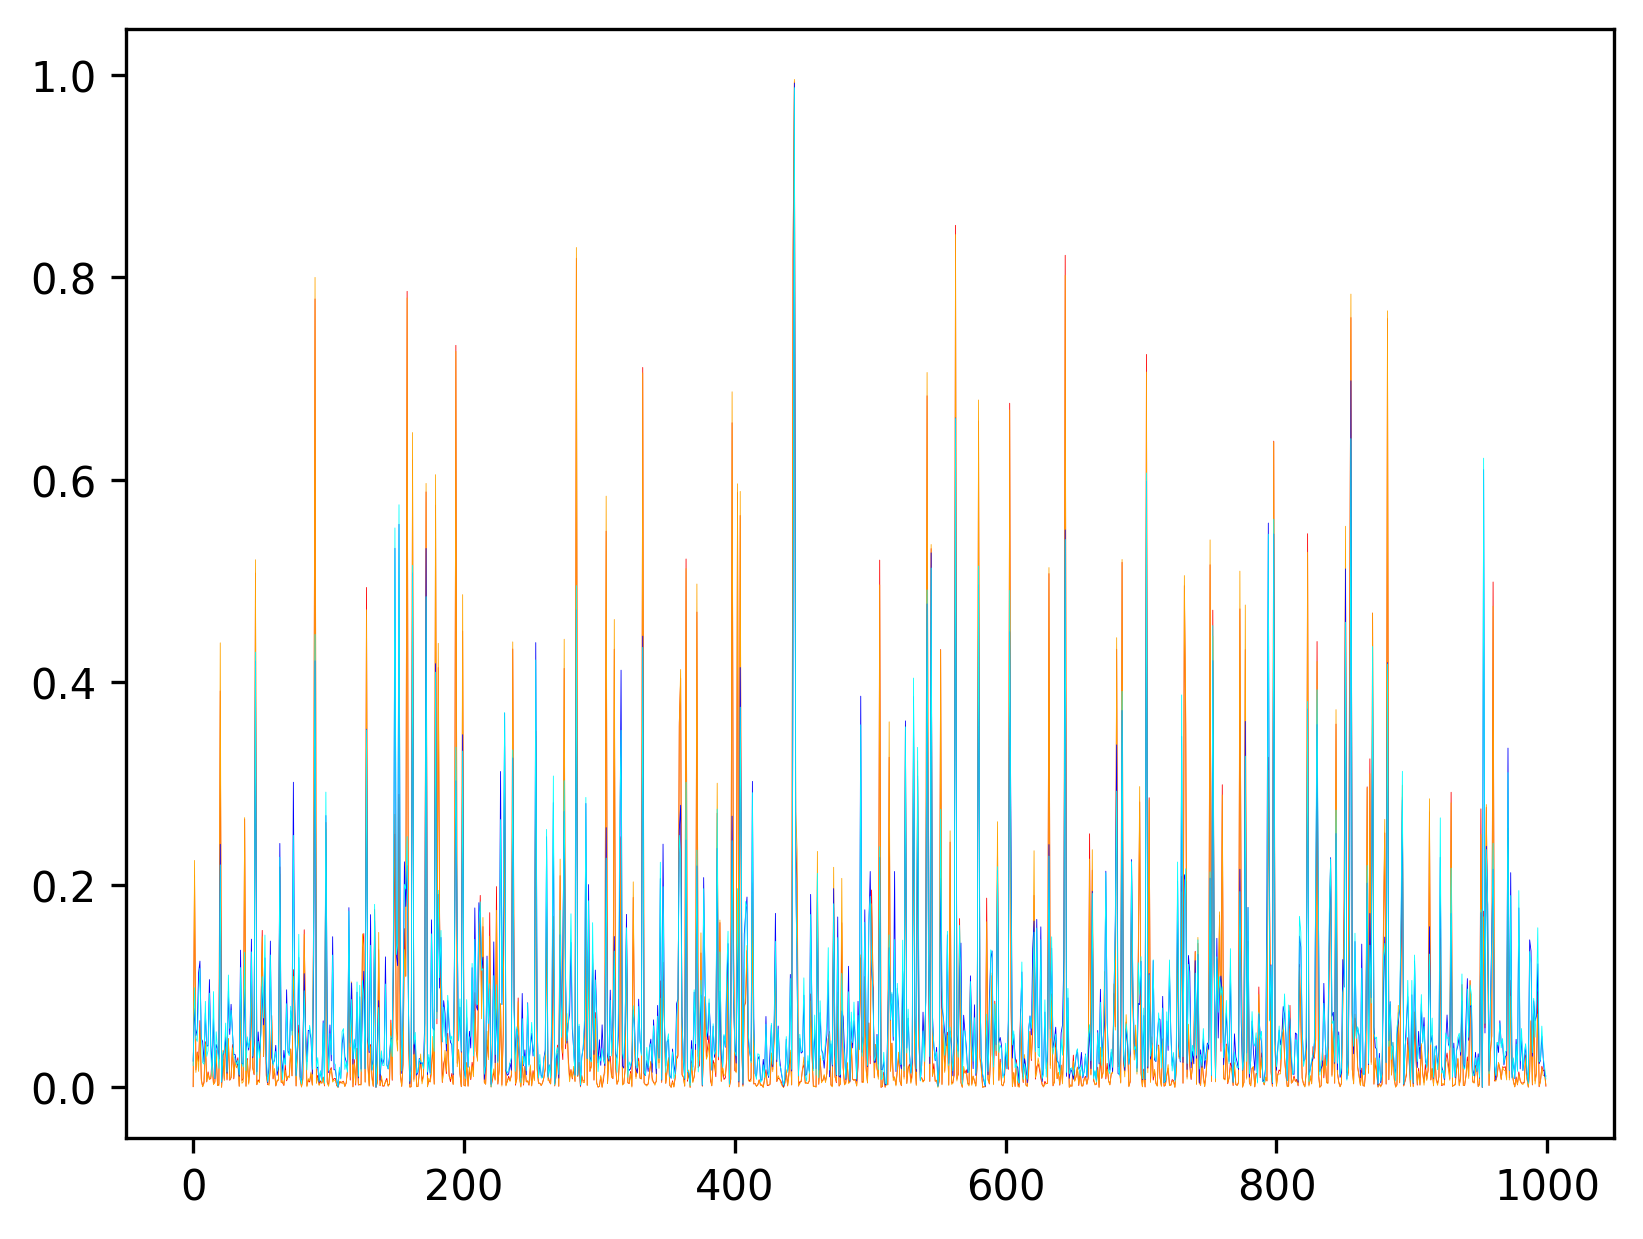

In [ ]:
import matplotlib.pyplot as plt
for layer in range(len(code_counters[0])):
    plt.figure()
    subsample = 1000
    plt.plot(code_counters[0][layer][:subsample], color='red', linewidth=0.2)
    plt.plot(code_counters[1][layer][:subsample], color='orange', linewidth=0.2)

    plt.plot(pile_counters[0][layer][:subsample], color='blue', linewidth=0.2)
    plt.plot(pile_counters[1][layer][:subsample], color='cyan', linewidth=0.2)

In [ ]:
ff_criterion = ( code_counters[0] > (2*pile_counters[0]) )

print( ff_criterion )